In [1]:
from pathlib import Path
import json

from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_utils import LabelledTraitData
from evaluation.evaluate_model import load_model

In [2]:
sns.set_style("white")

In [3]:
VARS = [
    'N.Percent', 'P.Percent',
    'K.Percent', 'Ca.Percent',
    'Mg.Percent', 'C.Percent',
    'Amax', 'Asat',
    'Area.cm2', 'Dry.mass.g',
    'Fresh.mass.g', 'Thickness.mm',
    'SLA.g.m2'
]

In [4]:
def qqplot(y, preds, ax, metrics, var):
    """Create a QQ plot of true vs predicted values."""
    minmax = 2.5
    r_squared = metrics['r_squared']
    mae = metrics['mae']

    quantiles = np.linspace(0.01, 0.99, 50, endpoint=True)
    y_q = np.quantile(y, quantiles)
    preds_q = np.quantile(preds, quantiles)

    sns.scatterplot(x=y_q, y=preds_q, ax=ax, alpha=0.8, s=24)
    ax.plot([-minmax, minmax], [-minmax, minmax], color='grey', linestyle='--')
    ax.set_title(f"{var} (R²: {r_squared:.2f}, MAE: {mae:.2f})")
    ax.set_xlabel("True quantiles")
    ax.set_ylabel("Predicted quantiles")
    ax.set_ylim(-minmax, minmax)
    ax.set_xlim(-minmax, minmax)

def plot_residuals(residuals, preds, ax, metrics, var):
    """Plot residuals vs predicted values."""
    r_squared = metrics['r_squared']
    mae = metrics['mae']
    i = VARS.index(var)

    sns.scatterplot(x=preds, y=residuals, ax=ax, alpha=0.5, s=24)

    ax.set_title(f"{var} (R²: {r_squared:.2f}, MAE: {mae:.2f})")
    ax.set_ylim(-2., 2.)
    ax.set_xlim(-3.5, 3.5)

    # Set labels for last subplots in column.
    if i > 9:
        ax.set_xlabel("Predicted values")
        ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
    else:
        ax.set_xticklabels([])

    if i % 3 == 0:
        ax.set_ylabel("Residuals")
    else:
        ax.set_yticklabels([])


In [5]:
dpath = Path('/Users/campbelli/Documents/geofm-plant-traits/data')
model_rpath = Path('/Users/campbelli/Documents/geofm-plant-traits/models/')

In [6]:
model_names = [
    'rf_bands_only',
    'rf_aux_vars',
    'gbdt_bands_only',
    'gbdt_aux_vars',
    'vanilla_nn_bands_only',
    'nn_aux_vars',
    'grf_bands_only',
    'grf_aux_vars',
]

In [7]:
# Declare model type.
model_name = model_names[5]
model_name = 'nn_aux_vars'
model_path = model_rpath / f'{model_name}.py'

In [8]:
# Load trait metadata (std and mean stats).
metadata_path = dpath / 'metadata'
with open(metadata_path / 'trait_stats.json', 'r') as f:
    trait_stats = json.load(f)

In [9]:
predictions = {}
true_vals = {}
residuals = {}
metrics = {}

In [10]:
for i, var in enumerate(VARS):
    model = load_model(model_path, 42, var)
    var_stats = trait_stats[var]
    model.set_stats(var_stats)

    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_train, y_train = dataset.train_data, dataset.train_labels
    X_val, y_val = dataset.val_data, dataset.val_labels
    X_test, y_test = dataset.test_data, dataset.test_labels

    X_train, y_train = model.configure_data(X_train, y_train)
    X_val, y_val = model.configure_data(X_val, y_val)
    X_test, y_test = model.configure_data(X_test, y_test)
    
    # Uses optimised hyperparameters
    model.fit(X_train, y_train, X_val, y_val)
    preds = model.predict(X_test)

    if type(preds) != np.ndarray:
        preds = preds.numpy().flatten()
        y_test = y_test.numpy().flatten()

    predictions[var] = preds
    true_vals[var] = y_test
    residuals[var] = y_test - preds
    metrics[var] = {
        'r_squared': model.score(X_test, y_test),
        'mae': mean_absolute_error(y_test, preds)
    }

Epoch 0, Loss: 0.44381576776504517, MAPE: 12.734862881785352
Epoch 5, Loss: 0.3755946457386017, MAPE: 11.147258810801357
Epoch 10, Loss: 0.40508604049682617, MAPE: 11.229995467039846
Epoch 15, Loss: 0.4134814143180847, MAPE: 11.555566007992821
Epoch 20, Loss: 0.4241217076778412, MAPE: 11.523553974880162
Epoch 25, Loss: 0.42975887656211853, MAPE: 11.599886304078186
Epoch 30, Loss: 0.4445980191230774, MAPE: 12.01872914627483
Epoch 35, Loss: 0.4252363443374634, MAPE: 11.599003213354417
Epoch 40, Loss: 0.40409648418426514, MAPE: 11.703328771202173
Epoch 45, Loss: 0.4009411931037903, MAPE: 11.681514427205355
Epoch 50, Loss: 0.45978623628616333, MAPE: 12.159063764395443
Epoch 55, Loss: 0.46910610795021057, MAPE: 13.089250757672799
Epoch 60, Loss: 0.430414617061615, MAPE: 12.046547396141378
Epoch 65, Loss: 0.43437013030052185, MAPE: 11.784402094452942
Epoch 70, Loss: 0.42566803097724915, MAPE: 11.96829597889115
Epoch 75, Loss: 0.408469557762146, MAPE: 11.419350413849253
Epoch 80, Loss: 0.4385

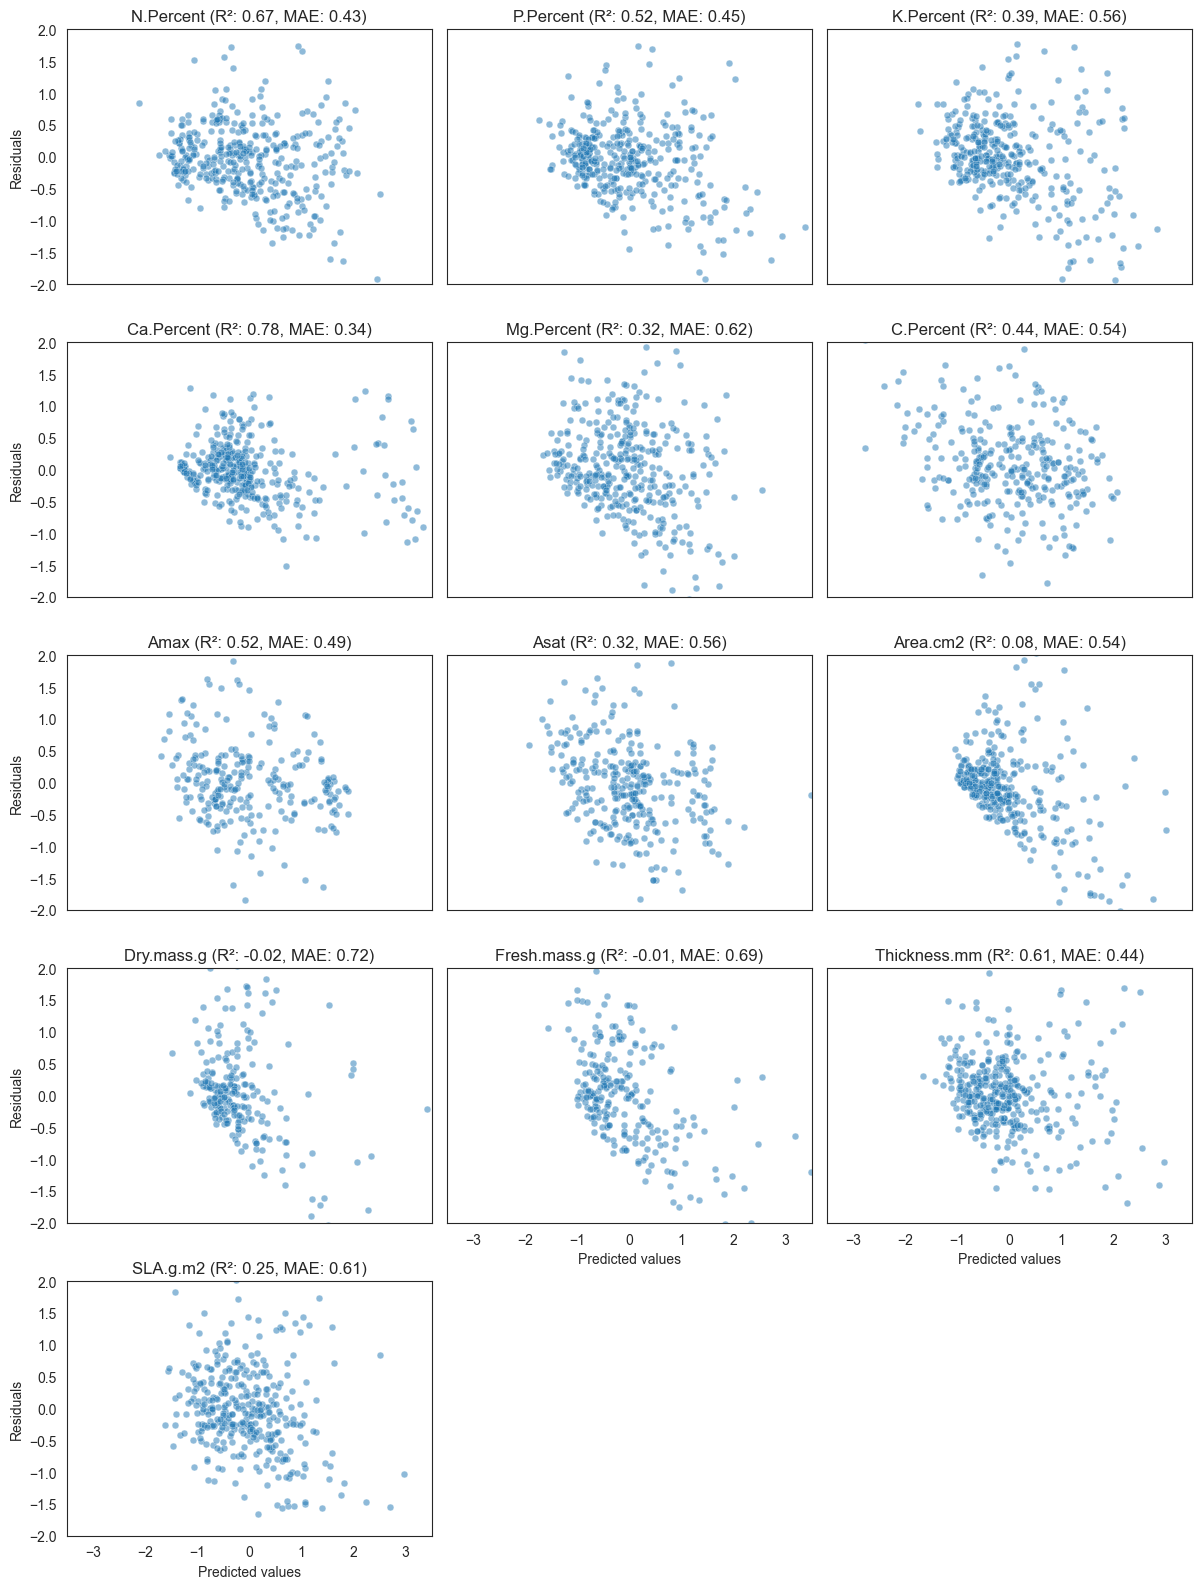

In [11]:
# Plot residuals for each different variable on a single plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16))

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for var in VARS:
    i = VARS.index(var)
    ax = axes.flat[i]
    preds = predictions[var]
    res = residuals[var]
    var_metrics = metrics[var]

    fig = plot_residuals(res, preds, ax, var_metrics, var)

plt.savefig(f"../figures/models/residuals_{model_name}_2layers_noreg_nobatchnorm.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

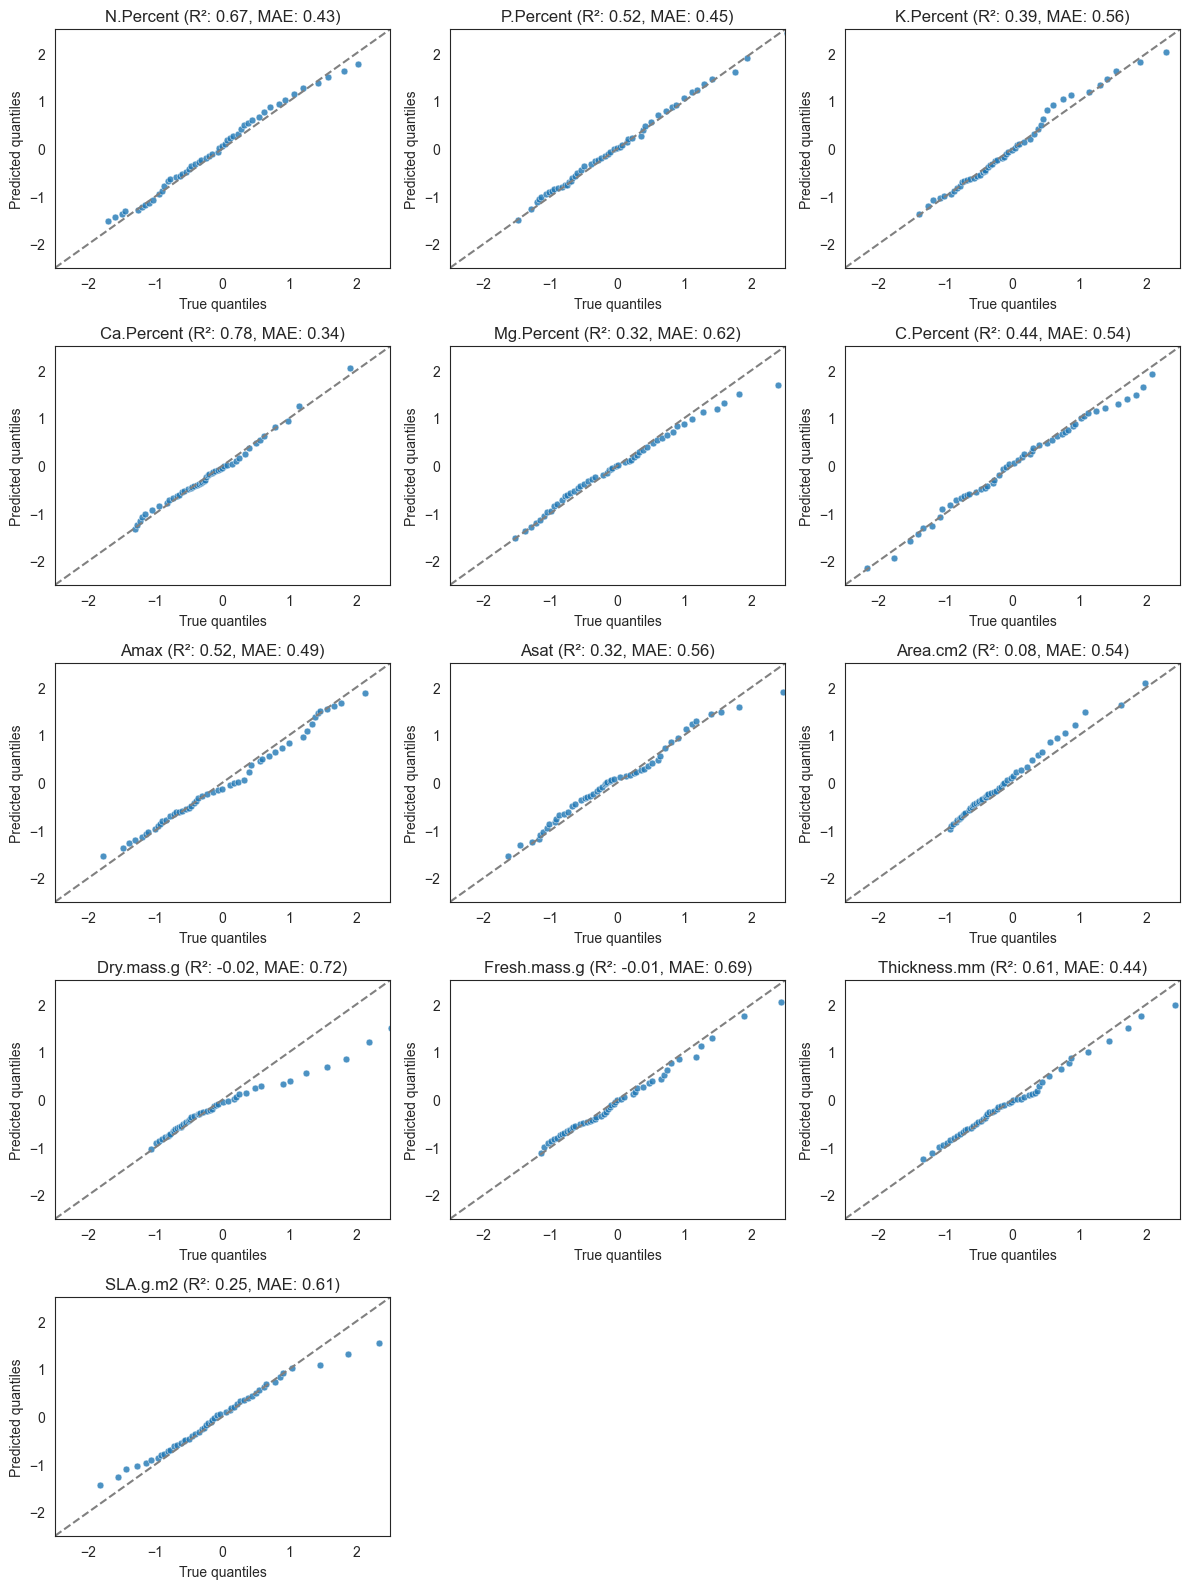

In [12]:
# Plot QQplot for each different variable on a single plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16))

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for var in VARS:
    i = VARS.index(var)
    ax = axes.flat[i]
    preds = predictions[var]
    trues = true_vals[var]
    var_metrics = metrics[var]

    fig = qqplot(trues, preds, ax, var_metrics, var)
    
plt.savefig(f"../figures/models/qqplot_{model_name}_2layers_noreg_nobatchnorm.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()